In [39]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Part 3: Variable Resolution Classifier
class VariableResCNN(nn.Module):
    def __init__(self, num_classes=10, num_filters=64, pooling="max"):
        super(VariableResCNN, self).__init__()
        self.pooling = pooling
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.AdaptiveMaxPool2d(1) if pooling == "max" else nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Data Preparation for Variable Resolution Dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Assuming variable resolution MNIST dataset is downloaded and organized
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from glob import glob
from PIL import Image

class VariableResolutionMNIST(Dataset):
    def __init__(self, root, transform=None):
        self.files = []
        self.labels = []
        self.transform = transform

        for label in range(10):
            filepaths = glob(f"{root}/{label}/*.png")
            self.files.extend(filepaths)
            self.labels.extend([label] * len(filepaths))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("L")

        if self.transform:
            image = self.transform(image)

        return image, label

def get_data_loaders(data_dir, batch_size=32):
    """Prepare data loaders for training, validation, and testing."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
    test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

    train_size = len(train_data) - 10000
    val_size = 10000
    traindata, valdata = random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    trainloader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = DataLoader(valdata, batch_size=batch_size, shuffle=False, num_workers=2)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, valloader, testloader

trainloader, valloader, testloader = get_data_loaders(data_dir = 'data/mnist-varres')

data_loaders = {
    "train": trainloader,
    "val": valloader,
    "test": testloader
}

# Training Loop

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(dataloaders['val'].dataset)
        val_acc = correct / total

        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

# Initialize Model and Experiment
results = []
pooling_methods = ["max", "mean"]
num_filters_list = [32, 48, 64]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

for pooling in pooling_methods:
    for num_filters in num_filters_list:
        print(f"\nTesting with Pooling: {pooling}, Num Filters: {num_filters}")
        model = VariableResCNN(num_classes=10, num_filters=num_filters, pooling=pooling).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        history = train_model(model, data_loaders, criterion, optimizer, device, num_epochs=5)

        torch.save(model.state_dict(), f"variable_res_cnn_{pooling}_{num_filters}.pth")

        plt.figure()
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title(f'Loss over Epochs ({pooling}, {num_filters})')
        plt.savefig(f'loss_{pooling}_{num_filters}.png')

        plt.figure()
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.legend()
        plt.title(f'Validation Accuracy ({pooling}, {num_filters})')
        plt.savefig(f'accuracy_{pooling}_{num_filters}.png')

        results.append({
            "pooling": pooling,
            "num_filters": num_filters,
            "val_acc": history['val_acc'][-1]
        })

# Display Results
for result in results:
    print(f"Pooling: {result['pooling']}, Num Filters: {result['num_filters']}, Final Val Acc: {result['val_acc']:.4f}")



Testing with Pooling: max, Num Filters: 32


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [3, 32, 32] at entry 0 and [3, 64, 64] at entry 1


In [40]:
import torch
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

# Part 3: Variable Resolution Classifier
class VariableResCNN(nn.Module):
    def __init__(self, num_classes=10, num_filters=64, pooling="max"):
        super(VariableResCNN, self).__init__()
        self.pooling = pooling
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.AdaptiveMaxPool2d(1) if pooling == "max" else nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Data Preparation for Variable Resolution Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class VariableResolutionMNIST(Dataset):
    def __init__(self, root, transform=None, resize_to=(32, 32)):
        self.files = []
        self.labels = []
        self.transform = transform
        self.resize_to = resize_to

        for label in range(10):
            filepaths = glob(f"{root}/{label}/*.png")
            self.files.extend(filepaths)
            self.labels.extend([label] * len(filepaths))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("L")

        if self.resize_to is not None:
            image = image.resize(self.resize_to)

        if self.transform:
            image = self.transform(image)

        return image, label

# Load Data
resize_resolution = (64, 64)  # Resize all images to 64x64 for uniformity
train_data = VariableResolutionMNIST("./mnist-varres/train", transform=transform, resize_to=resize_resolution)
val_data = VariableResolutionMNIST("./mnist-varres/test", transform=transform, resize_to=resize_resolution)

data_loaders = {
    "train": DataLoader(train_data, batch_size=16, shuffle=True),
    "val": DataLoader(val_data, batch_size=16, shuffle=False)
}

# Training Loop

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(dataloaders['val'].dataset)
        val_acc = correct / total

        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

# Initialize Model and Experiment
results = []
pooling_methods = ["max", "mean"]
num_filters_list = [32, 64, 128]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

for pooling in pooling_methods:
    for num_filters in num_filters_list:
        print(f"\nTesting with Pooling: {pooling}, Num Filters: {num_filters}")
        model = VariableResCNN(num_classes=10, num_filters=num_filters, pooling=pooling).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        history = train_model(model, data_loaders, criterion, optimizer, device, num_epochs=5)

        torch.save(model.state_dict(), f"variable_res_cnn_{pooling}_{num_filters}.pth")

        plt.figure()
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title(f'Loss over Epochs ({pooling}, {num_filters})')
        plt.savefig(f'loss_{pooling}_{num_filters}.png')

        plt.figure()
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.legend()
        plt.title(f'Validation Accuracy ({pooling}, {num_filters})')
        plt.savefig(f'accuracy_{pooling}_{num_filters}.png')

        results.append({
            "pooling": pooling,
            "num_filters": num_filters,
            "val_acc": history['val_acc'][-1]
        })

# Display Results
for result in results:
    print(f"Pooling: {result['pooling']}, Num Filters: {result['num_filters']}, Final Val Acc: {result['val_acc']:.4f}")


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [30]:
model_32 = VariableResolutionNetwork(32, pooling="mean")
model_48 = VariableResolutionNetwork(48, pooling="mean")
model_64 = VariableResolutionNetwork(64, pooling="mean")


In [33]:
for i in model_32.parameters():
    print(i.size())


torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [34]:
for i in model_48.parameters():
    print(i.size())

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([48, 32, 3, 3])
torch.Size([48])
torch.Size([10, 48])
torch.Size([10])


In [51]:
def calculate_total_parameters(model):
    final = 0
    for i in model.parameters():
        result = 1
        for j in i.size():
            result *= j
        final += result
    return final

In [55]:
a = calculate_total_parameters(model_32)
a

14666

In [56]:
b = calculate_total_parameters(model_48)
b

19450

In [57]:
c = calculate_total_parameters(model_64)
c

24234

In [58]:
(a + b + c) / 3

19450.0

Running experiment with N=32, pooling=max, additional_conv=False
Epoch 1/10, Loss: 0.5018, Val Accuracy: 0.8596
Epoch 2/10, Loss: 0.4157, Val Accuracy: 0.8596
Epoch 3/10, Loss: 0.4147, Val Accuracy: 0.8596
Epoch 4/10, Loss: 0.4138, Val Accuracy: 0.8596
Epoch 5/10, Loss: 0.4130, Val Accuracy: 0.8596
Epoch 6/10, Loss: 0.4129, Val Accuracy: 0.8596
Epoch 7/10, Loss: 0.4123, Val Accuracy: 0.8596
Epoch 8/10, Loss: 0.4122, Val Accuracy: 0.8596
Epoch 9/10, Loss: 0.4119, Val Accuracy: 0.8596
Epoch 10/10, Loss: 0.4115, Val Accuracy: 0.8596


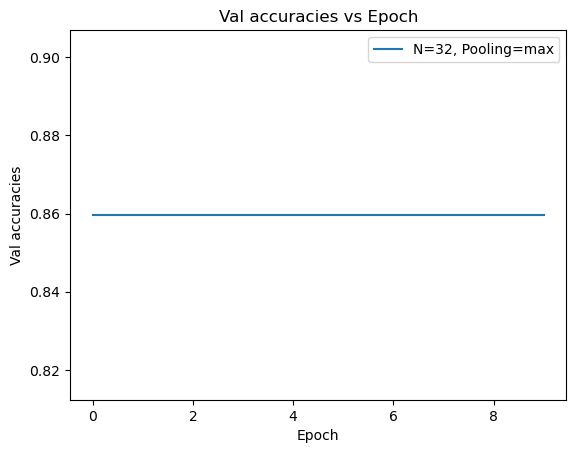

In [4]:
N_values = [32]

# Part 15: Run experiments for global max pooling
max_pool_results = experiment(N_values, pooling_type="max", epochs=10, batch_size=32, lr=0.0001)
plot_results(max_pool_results, metric="val_accuracies")

In [27]:
import os
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据路径
data_path = "data/mnist-varres/"

def get_data_loaders(data_dir, batch_size=32):
    """Prepare data loaders for training, validation, and testing."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
    test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

    train_size = len(train_data) - 10000
    val_size = 10000
    traindata, valdata = random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    trainloader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = DataLoader(valdata, batch_size=batch_size, shuffle=False, num_workers=2)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, valloader, testloader

# 构建网络
class VariableResolutionCNN(nn.Module):
    def __init__(self, n, num_classes=10, pooling_type='max'):
        super(VariableResolutionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, n, kernel_size=3, stride=1, padding=1)
        self.pooling_type = pooling_type
        if pooling_type == 'max':
            self.global_pool = nn.AdaptiveMaxPool2d(1)  # 全局最大池化
        elif pooling_type == 'mean':
            self.global_pool = nn.AdaptiveAvgPool2d(1)  # 全局平均池化
        self.fc = nn.Linear(n, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)  # 第一次池化
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  # 第二次池化
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)  # 第三次池化
        x = self.global_pool(x)  # 全局池化，映射到固定大小
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# 训练函数
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history.append((epoch_loss, epoch_acc))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    return history

# 测试函数
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / total
    return accuracy

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()

# 对比不同输入分辨率和全局池化方法
results = []
# pools = ['max', 'mean']
# n_values = [32, 48, 64]
pools = ['max']
n_values = [32]
trainloader, valloader, testloader = get_data_loaders(data_path, batch_size=32)
for pooling in pools:
    for n in n_values:
        print(f"Training with {pooling} pooling...")
        model = VariableResolutionCNN(n=n, pooling_type=pooling).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        history = train_model(model, trainloader, criterion, optimizer, num_epochs=10)
        test_accuracy = test_model(model, testloader)
        results.append({'pooling': pooling, 'test_accuracy': test_accuracy})

        # 保存历史记录
        history_df = pd.DataFrame(history, columns=['loss', 'accuracy'])
        history_df.to_csv(f'results_{pooling}_pooling.csv', index=False)

        # 绘制训练曲线
        plt.plot(range(1, 11), history_df['accuracy'], label=f'{pooling} pooling')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.savefig('pooling_comparison.png')
plt.show()

# 保存结果
results_df = pd.DataFrame(results)
results_df.to_csv('pooling_results.csv', index=False)

# 打印最终测试结果
print(results_df)


Training with max pooling...


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jalon\anaconda3\envs\deepLearning_asg3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 271, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Trying to resize storage that is not resizable


In [21]:
N_values = [32, 48, 64]
results_max = experiment(N_values, pooling_type="max", epochs=10)
results_mean = experiment(N_values, pooling_type="mean", epochs=10)

# 可视化结果
import matplotlib.pyplot as plt

N_list = [result['N'] for result in results_max]
accuracy_max = [result['accuracy'] for result in results_max]
accuracy_mean = [result['accuracy'] for result in results_mean]

plt.plot(N_list, accuracy_max, label="Global Max Pool")
plt.plot(N_list, accuracy_mean, label="Global Mean Pool")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs N")
plt.show()


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: './mnist-varres/train'